In [1]:
import numpy as np
import matplotlib.pyplot as plt

from TidalPy.RadialSolver import radial_solver
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
from TidalPy.utilities.graphics.multilayer import yplot

In [2]:
# Define planetary parameters
planet_mass = 6.417e23
planet_radius = 3.39e6
planet_volume = (4. / 3.) * np.pi * (planet_radius**3)
planet_bulk_density = planet_mass / planet_radius

forcing_frequency = 2. * np.pi / (7.66 * 60 * 60)  # Phobos orbital freq

# Simple interior structure of solid IC, liquid OC, solid mantle
N = 40
ICB = (1. / 3.) * planet_radius
CMB = (2. / 3.) * planet_radius
radius_array = np.concatenate(
    (
    np.linspace(0.1, ICB, N),
    np.linspace(ICB, CMB, N+1)[1:],
    np.linspace(CMB, planet_radius, N+1)[1:]
    )
)
shear_array = np.concatenate(
    (
    100.0e9 * np.ones(N, dtype=np.float64),
    0.0 * np.ones(N, dtype=np.float64),
    50.0e9 * np.ones(N, dtype=np.float64),
    )
)
viscosity_array = np.concatenate(
    (
    1.0e24 * np.ones(N, dtype=np.float64),
    1.0e10 * np.ones(N, dtype=np.float64),
    1.0e20 * np.ones(N, dtype=np.float64),
    )
)
bulk_mod_array = np.concatenate(
    (
    1.0e11 * np.ones(N, dtype=np.float64),
    1.0e11 * np.ones(N, dtype=np.float64),
    1.0e11 * np.ones(N, dtype=np.float64),
    )
)
density_array = np.concatenate(
    (
    8000. * np.ones(N, dtype=np.float64),
    4500. * np.ones(N, dtype=np.float64),
    3500. * np.ones(N, dtype=np.float64),
    )
)

volume_array, mass_array, gravity_array = \
    calculate_mass_gravity_arrays(radius_array, density_array)

Purely Elastic Body
k2=[-3.4104353e+13-0.j], h2=[-6.85860708e+13+0.j], l2=[-8.30546977e+12+0.j]


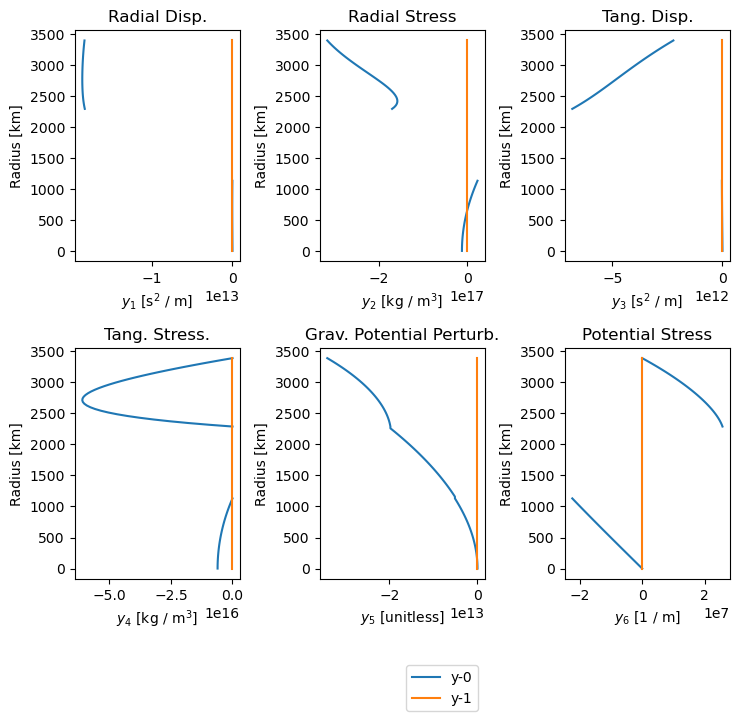

In [3]:
# Purely Elastic Body
from TidalPy.rheology import Elastic

elastic_rheology = Elastic()
# Calculate the "complex" shear (really all Im[mu] = 0)
complex_shear = np.empty(radius_array.shape, dtype=np.complex128)
elastic_rheology.vectorize_modulus_viscosity(forcing_frequency, shear_array, viscosity_array, complex_shear)

radial_solution = \
    radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_mod_array,
        complex_shear,
        forcing_frequency,
        planet_bulk_density,
        layer_types=('solid', 'liquid', 'solid'),
        is_static_by_layer=(False, True, False),
        is_incompressible_by_layer=(False, False, False),
        upper_radius_by_layer=(ICB, CMB, planet_radius),
        degree_l=2,
        solve_for=('loading',),
        use_kamata=False,
        integration_method='RK45',
        integration_rtol = 1.0e-6,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = False,
        max_num_steps = 500_000,
        expected_size = 500,
        max_ram_MB = 500,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False
        )

print('Purely Elastic Body')
print(f'k2={radial_solution.k}, h2={radial_solution.h}, l2={radial_solution.l}')
_ = yplot([np.real(radial_solution.result), np.imag(radial_solution.result)], [radius_array, radius_array])


Viscoelastic Body
k2=[-3.4436779e+13+1.68414308e+11j], h2=[-6.9169192e+13+2.95423048e+11j], l2=[-8.42906848e+12+6.26431116e+10j]


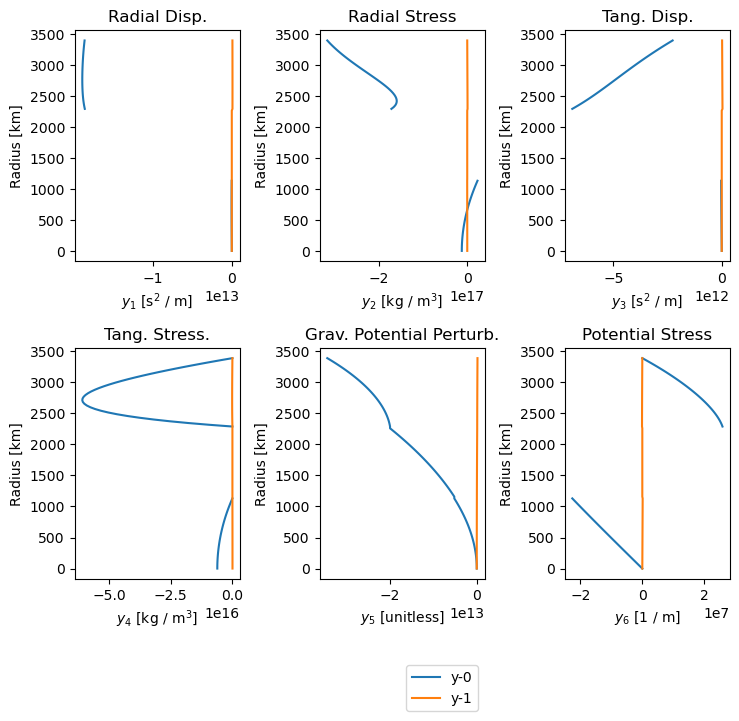

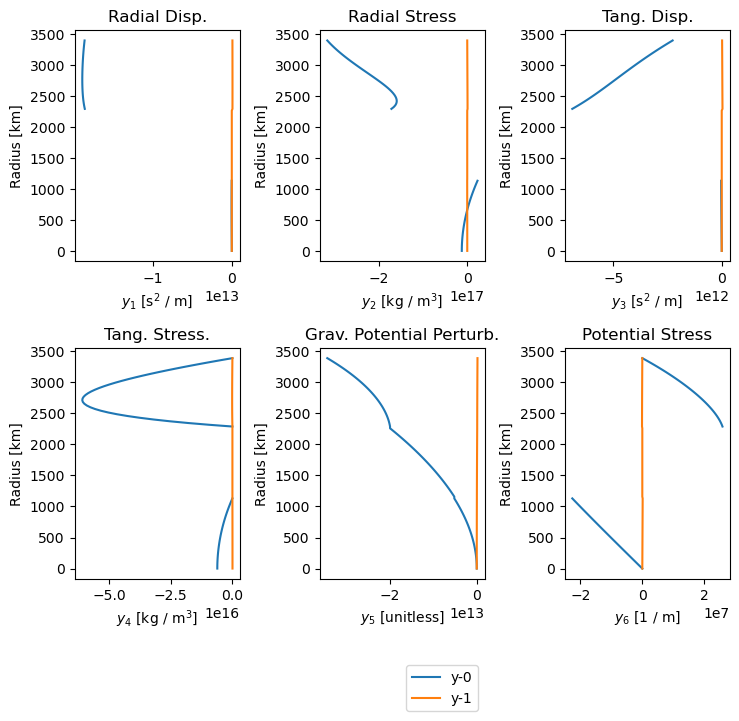

In [4]:
# Viscoelastic Body
from TidalPy.rheology import Andrade

andrade_rheology = Andrade()
# Calculate the "complex" shear (really all Im[mu] = 0)
complex_shear_andrade = np.empty(radius_array.shape, dtype=np.complex128)
andrade_rheology.vectorize_modulus_viscosity(forcing_frequency, shear_array, viscosity_array, complex_shear_andrade)

radial_solution = \
    radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_mod_array,
        complex_shear_andrade,
        forcing_frequency,
        planet_bulk_density,
        layer_types=('solid', 'liquid', 'solid'),
        is_static_by_layer=(False, True, False),
        is_incompressible_by_layer=(False, False, False),
        upper_radius_by_layer=(ICB, CMB, planet_radius),
        degree_l=2,
        solve_for=('loading',),
        use_kamata=False,
        integration_method='RK45',
        integration_rtol = 1.0e-4,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = False,
        max_num_steps = 500_000,
        expected_size = 500,
        max_ram_MB = 500,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False
        )

print('Viscoelastic Body')
print(f'k2={radial_solution.k}, h2={radial_solution.h}, l2={radial_solution.l}')
yplot([np.real(radial_solution.result), np.imag(radial_solution.result)], [radius_array, radius_array])
